In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
import os.path as osp
import os
import torch
import torch_geometric as tg
import pickle
from collections import defaultdict

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
%ls .exported_datasets/coauthor_cs/hybrid-perturbations

split-0.pkl  split-1.pkl  split-2.pkl  split-3.pkl  split-4.pkl


In [4]:
with open('.exported_datasets/cora_full/hybrid-left-out-classes/split-0.pkl', 'rb') as f:
    storage = pickle.load(f)
    storage.keys()

In [5]:
storage['data']['test']['x'].size()

torch.Size([2419, 8710])

In [6]:
auroc_mask = storage['data']['ood-test'].auroc_mask
auroc_mask.sum() / auroc_mask.size(0)

tensor(0.9807)

In [7]:
import data.constants as dc
from util import all_equal

In [8]:
df = []

for dataset in (dc.CORA_FULL, dc.AMAZON_PHOTO, dc.CITESEER, dc.COAUTHOR_CS, dc.PUBMED, ):
    print(f'Analyzing {dataset}')
    base_dir = osp.join('.exported_datasets', dataset)
    for setting in ('hybrid', 'transductive'):
        for ood_type, (_ood_val, _ood_test) in (
            ('left-out-classes', ('ood-val', 'ood-test')), 
            # Both bernoulli and normal perturbations follow the same structure
            ('perturbations', ('ood-val-ber', 'ood-test-ber'))):


            split_dir = osp.join(base_dir, f'{setting}-{ood_type}')
            for fn in [osp.join(split_dir, fn) for fn in os.listdir(split_dir)]:
                with open(fn, 'rb') as f:
                    storage = pickle.load(f)
                    datasets = storage['data']

                    n_train = datasets['train'].x.size(0)
                    n_full = datasets['ood-test'].x.size(0)

                    label_u = datasets['train'].y.numpy()[datasets['train'].edge_index[0]]
                    label_v = datasets['train'].y.numpy()[datasets['train'].edge_index[1]]
                    
                    label_utest = datasets['ood-test'].y.numpy()[datasets['ood-test'].edge_index[0]]
                    label_vtest = datasets['ood-test'].y.numpy()[datasets['ood-test'].edge_index[1]]
                    
                    auroc_mask = datasets[_ood_test].auroc_mask.cpu().numpy()
                    fraction_dropped_ood = 1 - (auroc_mask.sum() / auroc_mask.shape[0])

                    train_labels = set(datasets['train'].y[datasets['train'].mask].numpy())
                    ood_labels = set(datasets['ood-test'].y[datasets['ood-test'].mask].numpy()) - train_labels

                    is_ood_label = np.zeros(datasets['ood-test'].x.size(0))
                    for label in ood_labels:
                        is_ood_label[datasets['ood-test'].y == label] = True

                    # For both ood-val and ood-test count many have the 'ood' tag
                    mask_ood_val_test = datasets['ood-val'].mask | datasets['ood-test'].mask
                    is_ood = ~(datasets[_ood_test].is_in_distribution[mask_ood_val_test])
                    fraction_ood_tag = is_ood.float().mean()
                    
                    # Average feature nnz
                    avg_feature_nnz = (datasets['ood-val'].x > 0).float().mean(1).mean(0).item()
                    max_feature_nnz = (datasets['ood-val'].x > 0).float().mean(1).max(0)[0].item()
                    min_feature_nnz = (datasets['ood-val'].x > 0).float().mean(1).min(0)[0].item()
                    

                    df.append({
                        'Train Vertices' : n_train,
                        'Features' : datasets['train'].x.size(1),
                        'Train Edges' : datasets['train'].edge_index.size(1),
                        'Fraction Dropped' : 1 - (n_train / n_full),
                        'Fraction OOD labels' : is_ood_label.sum() / is_ood_label.shape[0],
                        'Train Edge Density' : datasets['train'].edge_index.size(1) / (datasets['train'].x.size(0)**2),
                        'Fraction OOD tag in OOD dataset' : fraction_ood_tag.item(),
                        'Train Classes' : datasets['train'].y.max().item() + 1,
                        'Setting' : setting,
                        'OOD Experiment' : ood_type,
                        'Homophily Train Graph' : (label_u == label_v).sum() / label_u.shape[0],
                        'Homophily OOD Graph' : (label_utest == label_vtest).sum() / label_utest.shape[0],
                        'Dataset' : dataset,
                        'Average Feature NNZ' : avg_feature_nnz,
                        'Max Feature NNZ' : max_feature_nnz,
                        'Min Feature NNZ' : min_feature_nnz,
                        'Fraction Dropped OOD' : fraction_dropped_ood,
                    })









Analyzing cora_full
Analyzing amazon_photo
Analyzing citeseer
Analyzing coauthor_cs
Analyzing pubmed


In [9]:
df = pd.DataFrame(df)

In [10]:
df.index

RangeIndex(start=0, stop=100, step=1)

In [11]:
df

,Train Vertices,Features,Train Edges,Fraction Dropped,Fraction OOD labels,Train Edge Density,Fraction OOD tag in OOD dataset,Train Classes,Setting,OOD Experiment,Homophily Train Graph,Homophily OOD Graph,Dataset,Average Feature NNZ,Max Feature NNZ,Min Feature NNZ,Fraction Dropped OOD
0,2438,8710,12910,0.464529,0.374259,0.002172,0.805674,7,hybrid,left-out-classes,0.783269,0.800294,cora_full,0.006713,0.025832,0.00023,0.019328
1,2425,8710,12990,0.467384,0.374259,0.002209,0.800752,7,hybrid,left-out-classes,0.775828,0.800294,cora_full,0.006713,0.025832,0.00023,0.019328
2,2419,8710,13166,0.468702,0.374259,0.002250,0.798500,7,hybrid,left-out-classes,0.790977,0.800294,cora_full,0.006713,0.025832,0.00023,0.019328
3,2434,8710,12898,0.465407,0.374259,0.002177,0.804153,7,hybrid,left-out-classes,0.785238,0.800294,cora_full,0.006713,0.025832,0.00023,0.019328
4,2434,8710,12822,0.465407,0.374259,0.002164,0.804153,7,hybrid,left-out-classes,0.779130,0.800294,cora_full,0.006713,0.025832,0.00023,0.019328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,19717,500,88648,0.000000,0.000000,0.000228,0.526316,3,transductive,perturbations,0.802387,0.802387,pubmed,0.100221,0.244000,0.01000,0.000000
96,19717,500,88648,0.000000,0.000000,0.000228,0.526316,3,transductive,perturbations,0.802387,0.802387,pubmed,0.100221,0.244000,0.01000,0.000000
97,19717,500,88648,0.000000,0.000000,0.000228,0.526316,3,transductive,perturbations,0.802387,0.802387,pubmed,0.100221,0.244000,0.01000,0.000000
98,19717,500,88648,0.000000,0.000000,0.000228,0.526316,3,transductive,perturbations,0.802387,0.802387,pubmed,0.100221,0.244000,0.01000,0.000000


In [12]:
means = df.groupby(by=['Dataset', 'Setting', 'OOD Experiment']).mean()
stds = df.groupby(by=['Dataset', 'Setting', 'OOD Experiment']).std()

In [13]:
means.loc[(dc.CORA_FULL, 'hybrid', dc.LEFT_OUT_CLASSES)]

Train Vertices                      2430.000000
Features                            8710.000000
Train Edges                        12957.200000
Fraction Dropped                       0.466286
Fraction OOD labels                    0.374259
Train Edge Density                     0.002194
Fraction OOD tag in OOD dataset        0.802646
Train Classes                          7.000000
Homophily Train Graph                  0.782888
Homophily OOD Graph                    0.800294
Average Feature NNZ                    0.006713
Max Feature NNZ                        0.025832
Min Feature NNZ                        0.000230
Fraction Dropped OOD                   0.019328
Name: (cora_full, hybrid, left-out-classes), dtype: float64

In [14]:
#means.loc[('amazon_computers',       'hybrid', 'left-out-classes')]

In [15]:
df_clean = []
for dataset in (dc.CORA_FULL, dc.AMAZON_PHOTO, dc.CITESEER, dc.COAUTHOR_CS, dc.PUBMED, ):
    homophily = means.loc[(dataset, 'transductive', 'left-out-classes')]['Homophily Train Graph']
    loc_frac = means.loc[(dataset, 'hybrid', 'left-out-classes')]['Fraction OOD labels']
    edge_density = means.loc[(dataset, 'hybrid', 'left-out-classes')]['Train Edge Density']
    
    # Homophily on inductive train graphs
    homophily_loc_train_mean = means.loc[(dataset, 'hybrid', 'left-out-classes')]['Homophily Train Graph']
    homophily_loc_train_std = stds.loc[(dataset, 'hybrid', 'left-out-classes')]['Homophily Train Graph']
    
    homophily_per_train_mean = means.loc[(dataset, 'hybrid', 'perturbations')]['Homophily Train Graph']
    homophily_per_train_std = stds.loc[(dataset, 'hybrid', 'perturbations')]['Homophily Train Graph']
    
    # Dropped fraction on inductive train graphs
    frac_dropped_loc_train_mean = means.loc[(dataset, 'hybrid', 'left-out-classes')]['Fraction Dropped']
    frac_dropped_loc_train_std = stds.loc[(dataset, 'hybrid', 'left-out-classes')]['Fraction Dropped']
    
    frac_dropped_per_train_mean = means.loc[(dataset, 'hybrid', 'perturbations')]['Fraction Dropped']
    frac_dropped_per_train_std = stds.loc[(dataset, 'hybrid', 'perturbations')]['Fraction Dropped']
    
    # OOD fraction on inductive ood graphs
    frac_ood_loc_train_mean = means.loc[(dataset, 'hybrid', 'left-out-classes')]['Fraction OOD tag in OOD dataset']
    frac_ood_loc_train_std = stds.loc[(dataset, 'hybrid', 'left-out-classes')]['Fraction OOD tag in OOD dataset']
    
    frac_ood_per_train_mean = means.loc[(dataset, 'hybrid', 'perturbations')]['Fraction OOD tag in OOD dataset']
    frac_ood_per_train_std = stds.loc[(dataset, 'hybrid', 'perturbations')]['Fraction OOD tag in OOD dataset']
    
    avg_feature_nnz = means.loc[(dataset, 'transductive', 'left-out-classes')]['Average Feature NNZ']
    max_feature_nnz = means.loc[(dataset, 'transductive', 'left-out-classes')]['Max Feature NNZ']
    min_feature_nnz = means.loc[(dataset, 'transductive', 'left-out-classes')]['Min Feature NNZ']
    
    
    avg_feature_nnz_per = means.loc[(dataset, 'transductive', 'perturbations')]['Average Feature NNZ']
    max_feature_nnz_per = means.loc[(dataset, 'transductive', 'perturbations')]['Max Feature NNZ']
    min_feature_nnz_per = means.loc[(dataset, 'transductive', 'perturbations')]['Min Feature NNZ']
    
    excluded_loc = means.loc[(dataset, 'transductive', 'left-out-classes')]['Fraction Dropped OOD']
    
    df_clean.append({
        'Dataset' : dataset,
        'Vertices' : int(means.loc[(dataset, 'transductive', 'left-out-classes')]['Train Vertices']),
        'Features' : int(means.loc[(dataset, 'transductive', 'left-out-classes')]['Features']),
        'Edges' : int(means.loc[(dataset, 'transductive', 'left-out-classes')]['Train Edges']),
        'Classes' : int(means.loc[(dataset, 'transductive', 'left-out-classes')]['Train Classes']),
        'Edge Density' : f'{edge_density:.4f}',
        '#LOC' : int(means.loc[(dataset, 'transductive', 'left-out-classes')]['Train Classes']) - int(means.loc[(dataset, 'hybrid', 'left-out-classes')]['Train Classes']),
        'LOC fraction' : f'{loc_frac:.3f}',
        'Homophily' : f'{homophily:.3f}',
        'Fraction ambiguous LOC' : f'{100 * excluded_loc:.1f}\\%',
        'Hybrid LOC train homophily' : f'{100 * homophily_loc_train_mean:.2f}\\% +- {100 * homophily_loc_train_std:.2f}\\%',
        'Hybrid Per. train homophily' : f'{100 * homophily_per_train_mean:.2f}\\% +- {100 * homophily_per_train_std:.2f}\\%',
        'Hybrid LOC dropped fraction' : f'{100 * frac_dropped_loc_train_mean:.2f}\\% +- {100 * frac_dropped_loc_train_std:.2f}\\%',
        'Hybrid Per. dropped fraction' : f'{100 * frac_dropped_per_train_mean:.2f}\\% +- {100 * frac_dropped_per_train_std:.2f}\\%',
        'Hybrid LOC ood fraction' : f'{100 * frac_ood_loc_train_mean:.2f}\\% +- {100 * frac_ood_loc_train_std:.2f}\\%',
        'Hybrid Per. ood fraction' : f'{100 * frac_ood_per_train_mean:.2f}\\% +- {100 * frac_ood_per_train_std:.2f}\\%',
        
        'Min. Feature nnz' : f'{100 * min_feature_nnz:.2f}\\%',
        'Avg. Feature nnz' : f'{100 * avg_feature_nnz:.2f}\\%',
        'Max. Feature nnz' : f'{100 * max_feature_nnz:.2f}\\%',
        
        
        'Min. Feature nnz (per)' : f'{100 * min_feature_nnz_per:.2f}\\%',
        'Avg. Feature nnz (per)' : f'{100 * avg_feature_nnz_per:.2f}\\%',
        'Max. Feature nnz (per)' : f'{100 * max_feature_nnz_per:.2f}\\%',
    })

df_clean = pd.DataFrame(df_clean)

df_clean.set_index('Dataset').loc[[dc.CORA_FULL, dc.CITESEER, dc.PUBMED, dc.COAUTHOR_CS, dc.AMAZON_PHOTO]].T


Dataset,cora_full,citeseer,pubmed,coauthor_cs,amazon_photo
Vertices,4553,2110,19717,18333,7487
Features,8710,3703,500,6805,745
Edges,28542,7388,88648,163788,238087
Classes,11,6,3,15,8
Edge Density,0.0022,0.0032,0.0005,0.0008,0.0058
#LOC,4,2,1,3,3
LOC fraction,0.374,0.398,0.393,0.413,0.247
Homophily,0.800,0.738,0.802,0.808,0.827
Fraction ambiguous LOC,1.9\%,35.5\%,34.6\%,22.2\%,7.3\%
Hybrid LOC train homophily,78.29\% +- 0.58\%,83.43\% +- 1.11\%,85.13\% +- 0.27\%,82.28\% +- 0.21\%,79.82\% +- 0.28\%


In [16]:
dfx = df_clean.set_index('Dataset').loc[[dc.CORA_FULL, dc.CITESEER, dc.PUBMED, dc.COAUTHOR_CS, dc.AMAZON_PHOTO]].T
for name, row in zip(dfx.index, dfx.to_numpy()):
    print(name)
    print(' & '.join(f'${i}$' for i in row))
    print()
    print()

Vertices
$4553$ & $2110$ & $19717$ & $18333$ & $7487$


Features
$8710$ & $3703$ & $500$ & $6805$ & $745$


Edges
$28542$ & $7388$ & $88648$ & $163788$ & $238087$


Classes
$11$ & $6$ & $3$ & $15$ & $8$


Edge Density
$0.0022$ & $0.0032$ & $0.0005$ & $0.0008$ & $0.0058$


#LOC
$4$ & $2$ & $1$ & $3$ & $3$


LOC fraction
$0.374$ & $0.398$ & $0.393$ & $0.413$ & $0.247$


Homophily
$0.800$ & $0.738$ & $0.802$ & $0.808$ & $0.827$


Fraction ambiguous LOC
$1.9\%$ & $35.5\%$ & $34.6\%$ & $22.2\%$ & $7.3\%$


Hybrid LOC train homophily
$78.29\% +- 0.58\%$ & $83.43\% +- 1.11\%$ & $85.13\% +- 0.27\%$ & $82.28\% +- 0.21\%$ & $79.82\% +- 0.28\%$


Hybrid Per. train homophily
$78.44\% +- 0.80\%$ & $73.92\% +- 1.19\%$ & $80.27\% +- 0.41\%$ & $80.71\% +- 0.20\%$ & $82.70\% +- 0.43\%$


Hybrid LOC dropped fraction
$46.63\% +- 0.17\%$ & $57.02\% +- 0.68\%$ & $52.89\% +- 0.22\%$ & $48.35\% +- 0.16\%$ & $32.58\% +- 0.05\%$


Hybrid Per. dropped fraction
$24.16\% +- 1.18\%$ & $34.27\% +- 2.34\%$ & $27.56\

In [17]:
dfx = df_clean[[
    'Dataset',
    'Hybrid LOC train homophily',
    'Hybrid Per. train homophily',
    'Hybrid LOC dropped fraction',
    'Hybrid Per. dropped fraction',
    'Hybrid LOC ood fraction',
    'Hybrid Per. ood fraction',
    ]].set_index('Dataset')
for name, row in zip(dfx.index, dfx.to_numpy()):
    print(name)
    print(' & '.join(f'${i}$' for i in row))
    print()
    print()


cora_full
$78.29\% +- 0.58\%$ & $78.44\% +- 0.80\%$ & $46.63\% +- 0.17\%$ & $24.16\% +- 1.18\%$ & $80.26\% +- 0.29\%$ & $41.18\% +- 2.06\%$


amazon_photo
$79.82\% +- 0.28\%$ & $82.70\% +- 0.43\%$ & $32.58\% +- 0.05\%$ & $19.45\% +- 0.12\%$ & $75.80\% +- 0.13\%$ & $51.24\% +- 0.32\%$


citeseer
$83.43\% +- 1.11\%$ & $73.92\% +- 1.19\%$ & $57.02\% +- 0.68\%$ & $34.27\% +- 2.34\%$ & $69.82\% +- 0.84\%$ & $28.88\% +- 1.96\%$


coauthor_cs
$82.28\% +- 0.21\%$ & $80.71\% +- 0.20\%$ & $48.35\% +- 0.16\%$ & $21.18\% +- 0.25\%$ & $85.52\% +- 0.29\%$ & $47.06\% +- 0.56\%$


pubmed
$85.13\% +- 0.27\%$ & $80.27\% +- 0.41\%$ & $52.89\% +- 0.22\%$ & $27.56\% +- 0.50\%$ & $74.22\% +- 0.31\%$ & $36.26\% +- 0.65\%$




In [18]:
dfx

,Hybrid LOC train homophily,Hybrid Per. train homophily,Hybrid LOC dropped fraction,Hybrid Per. dropped fraction,Hybrid LOC ood fraction,Hybrid Per. ood fraction
Dataset,,,,,,
cora_full,78.29\% +- 0.58\%,78.44\% +- 0.80\%,46.63\% +- 0.17\%,24.16\% +- 1.18\%,80.26\% +- 0.29\%,41.18\% +- 2.06\%
amazon_photo,79.82\% +- 0.28\%,82.70\% +- 0.43\%,32.58\% +- 0.05\%,19.45\% +- 0.12\%,75.80\% +- 0.13\%,51.24\% +- 0.32\%
citeseer,83.43\% +- 1.11\%,73.92\% +- 1.19\%,57.02\% +- 0.68\%,34.27\% +- 2.34\%,69.82\% +- 0.84\%,28.88\% +- 1.96\%
coauthor_cs,82.28\% +- 0.21\%,80.71\% +- 0.20\%,48.35\% +- 0.16\%,21.18\% +- 0.25\%,85.52\% +- 0.29\%,47.06\% +- 0.56\%
pubmed,85.13\% +- 0.27\%,80.27\% +- 0.41\%,52.89\% +- 0.22\%,27.56\% +- 0.50\%,74.22\% +- 0.31\%,36.26\% +- 0.65\%


# Neighbourhood purity

In [19]:
storage['data']['ood-test']

Data(
  x=[19717, 500],
  edge_index=[2, 88648],
  y=[19717],
  mask=[19717],
  vertex_to_idx={
    node_0=0,
    node_1=1,
    node_2=2,
    node_3=3,
    node_4=4,
    node_5=5,
    node_6=6,
    node_7=7,
    node_8=8,
    node_9=9,
    node_10=10,
    node_11=11,
    node_12=12,
    node_13=13,
    node_14=14,
    node_15=15,
    node_16=16,
    node_17=17,
    node_18=18,
    node_19=19,
    node_20=20,
    node_21=21,
    node_22=22,
    node_23=23,
    node_24=24,
    node_25=25,
    node_26=26,
    node_27=27,
    node_28=28,
    node_29=29,
    node_30=30,
    node_31=31,
    node_32=32,
    node_33=33,
    node_34=34,
    node_35=35,
    node_36=36,
    node_37=37,
    node_38=38,
    node_39=39,
    node_40=40,
    node_41=41,
    node_42=42,
    node_43=43,
    node_44=44,
    node_45=45,
    node_46=46,
    node_47=47,
    node_48=48,
    node_49=49,
    node_50=50,
    node_51=51,
    node_52=52,
    node_53=53,
    node_54=54,
    node_55=55,
    node_56=56,
    node_57=

In [20]:
from torch_geometric.loader import DataLoader
from data.base import SingleGraphDataset
from evaluation.util import count_id_neighbours

thesis_nbs/data_plots/nb_purity_cora_full.pdf
thesis_nbs/data_plots/nb_purity_citeseer.pdf
thesis_nbs/data_plots/nb_purity_pubmed.pdf
thesis_nbs/data_plots/nb_purity_amazon_photo.pdf
thesis_nbs/data_plots/nb_purity_coauthor_cs.pdf


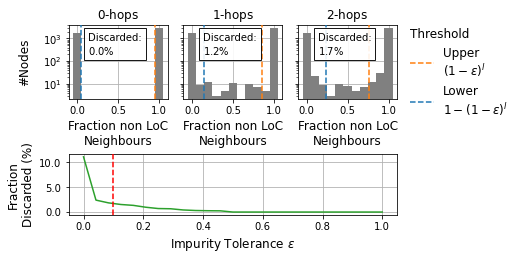

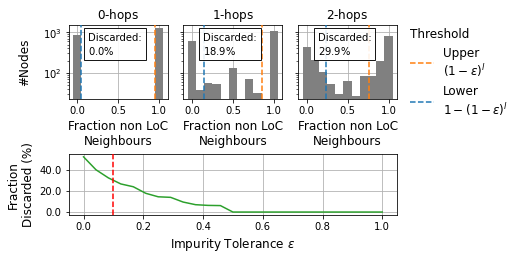

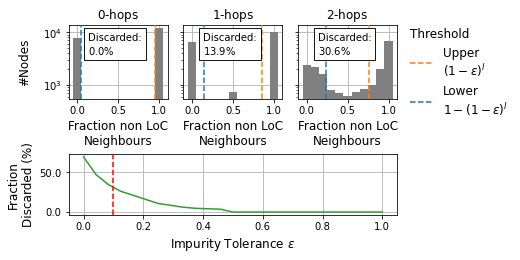

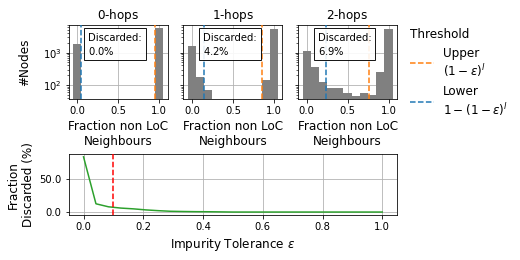

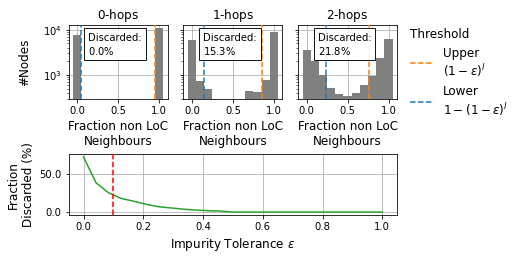

In [27]:
for dataset in [dc.CORA_FULL, dc.CITESEER, dc.PUBMED, dc.AMAZON_PHOTO, dc.COAUTHOR_CS]:

    with open(f'.exported_datasets/{dataset}/transductive-left-out-classes/split-0.pkl', 'rb') as f:
        storage = pickle.load(f)
        storage.keys()
    loader_ood_test = DataLoader(SingleGraphDataset(storage['data']['ood-test']))
    fraction_id_nbs = count_id_neighbours([loader_ood_test], 2, fraction=True, mask=False)

    fig = plt.figure(constrained_layout=True, figsize=(5.5, 3.5))
    gs = fig.add_gridspec(2,3, height_ratios=[0.55, 0.45], hspace=0.01)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
    ax2 = fig.add_subplot(gs[0, 2], sharey=ax0)
    axs_hist = [ax0, ax1, ax2]
    ax_eps = fig.add_subplot(gs[1, :])

    handles = []
    for i, ax in enumerate(axs_hist):
        eps = 0.1
        cutoff = (1 - eps)**i

        is_discarded = np.zeros_like(fraction_id_nbs[:, i]).astype(bool)
        for j in range(i + 1):
            fraction_id_nbs_j = fraction_id_nbs[:, j].numpy()
            cutoff_j = (1 - eps) ** j
            is_discarded |= (fraction_id_nbs_j < cutoff_j) & (fraction_id_nbs_j > (1 - cutoff_j))

        bin_centers = np.linspace(0, 1, 11)
        bin_width = bin_centers[1] - bin_centers[0]
        bin_idxs = np.abs(fraction_id_nbs[:, i][:, None].numpy() - bin_centers[None, :]).argmin(1)

        xs, heights = [], []
        for bin_idx, bin_center in enumerate(bin_centers):
            xs.append(bin_center)
            heights.append((bin_idxs == bin_idx).sum())
        ax.bar(xs, heights, width=bin_width, color='grey', alpha=1, zorder=4)
        ax.set_yscale('log')
        co = ax.axvline(cutoff - (bin_width / 2), c='tab:orange', ls='--', zorder=4)
        cb = ax.axvline(1 - cutoff + (bin_width / 2), c='tab:blue', ls='--', zorder=4)
        if i == 0:
            handles += [co, cb]

        props = dict(alpha=0.9, facecolor='white', edgecolor=None)
        # place a text box in upper left in axes coords
        ax.text(0.2, 0.9, f'Discarded:\n${100 * is_discarded.mean():.1f}\\%$', transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props, zorder=5)

        ax.grid(which='major', axis='both')

    for ax in axs_hist[1:]:
        plt.setp(ax.get_yticklabels(), visible=False)

    xs, ys = [], []
    for eps_i in np.linspace(0, 1, 25):
        cutoffs = np.array([(1-eps_i)**i for i in range(2 + 1)])
        fraction_id_nbs_npy = fraction_id_nbs.numpy()
        fraction_discarded = ((fraction_id_nbs_npy < cutoffs[None, :]) & (fraction_id_nbs_npy > (1 - cutoffs[None, :]))).any(1).mean()
        xs.append(eps_i)
        ys.append(100 * fraction_discarded)

    ax_eps.plot(xs, ys, zorder=4, c='tab:green')
    ax_eps.axvline(eps, c='red', ls='--', zorder=4)
    ax_eps.grid(which='major', axis='both')
    from matplotlib.ticker import FormatStrFormatter
    ax_eps.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    ax_eps.set_ylabel('Fraction\nDiscarded (%)', fontsize=12)
    ax_eps.set_xlabel('Impurity Tolerance $\\epsilon$', fontsize=12)
    axs_hist[0].set_ylabel('#Nodes', fontsize=12, labelpad=12)
    for i, ax in enumerate(axs_hist):
        ax.set_xlabel('Fraction non LoC\nNeighbours', fontsize=12)
        ax.set_title(f'${i}$-hops', fontsize=12)

    legend_proxy = fig.legend(handles, ['Upper\n$(1 - \\epsilon)^l$', 'Lower\n$1 - (1 - \\epsilon)^l$'], 
                              title='Threshold', loc='upper right', bbox_to_anchor=(1.3-0.00, 0.95), frameon=False, fontsize=12)
    plt.setp(legend_proxy.get_title(),fontsize=12)
    legend_proxy._legend_box.align = "left"

    path = f'thesis_nbs/data_plots/nb_purity_{dataset}.pdf'
    fig.savefig(path, bbox_inches='tight')
    print(path)


In [22]:
mask_vt = storage['data']['ood-test'].mask | storage['data']['ood-val'].mask

storage['data']['ood-test'].is_out_of_distribution[mask_vt].float().mean()



tensor(0.8763)

In [23]:

storage['data']['ood-test'].is_in_distribution[mask_vt].float().mean()

tensor(0.1237)

In [24]:

storage['data']['ood-test'].auroc_mask.float().mean()

tensor(0.7781)

(array([ 7580.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10753.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

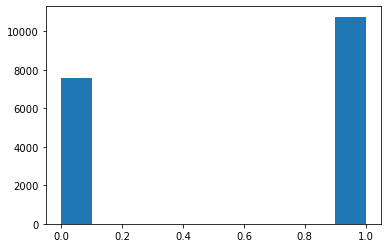

In [25]:
fig, ax = plt.subplots()
ax.hist(fraction_id_nbs[:, 0].flatten().numpy())